In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

In [2]:
# Load dataset
df = pd.read_csv("species_biome_env_dataset.csv")

# Metadata
biome_lookup = {
    1: "Tropical Forest", 2: "Temperate Forest", 3: "Boreal Forest",
    4: "Tropical Grassland", 5: "Temperate Grassland", 6: "Desert",
    7: "Shrubland", 8: "Tundra", 9: "Flooded Grassland", 10: "Mangroves",
    11: "Mediterranean", 12: "Montane", 13: "Xeric Shrubland", 14: "Ice and Rock"
}
species_cols = [
    "axolotl", "blue_macaw", "ocelot", "black_iguana", "resplendent_quetzal",
    "coyote", "crested_caracara", "green_turtle", "american_alligator", "asian_elephant"
]
biome_ids = sorted(df["BIOME"].dropna().unique())

# Prepare matrix and metrics
compatibility_matrix_knn_tuned = pd.DataFrame(index=species_cols, columns=[biome_lookup.get(b, f"Biome {b}") for b in biome_ids])
tuned_metrics = []

# Scoring and grid
f1_scorer = make_scorer(f1_score, zero_division=0)
param_grid = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"]
}

In [3]:
# Tuning loop
for species in species_cols:
    print(f"\n Tuning KNN for: {species}")
    y = df[species].astype(int)

    env_cols = [col for col in df.columns if col.startswith("BIO")]
    biome_encoded = pd.get_dummies(df["BIOME"], prefix="BIOME")
    X = pd.concat([df[env_cols], biome_encoded], axis=1)
    X = X.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean(numeric_only=True))
    y = y.loc[X.index]

    if y.value_counts().min() < 2:
        print(f"⚠️ Skipping {species} due to insufficient class diversity.")
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.25, random_state=42, stratify=y
        )
    except ValueError as ve:
        print(f" Skipping {species} — split error: {ve}")
        continue

    grid = GridSearchCV(
        KNeighborsClassifier(),
        param_grid,
        scoring=f1_scorer,
        cv=3,
        n_jobs=-1
    )

    try:
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    except Exception as e:
        print(f"Training failed for {species}: {e}")
        continue

    y_pred = best_model.predict(X_test)
    probas = best_model.predict_proba(X_scaled)[:, 1]

    print(f"Best F1: {f1_score(y_test, y_pred):.3f} | Params: {grid.best_params_}")

    tuned_metrics.append({
        "Species": species,
        "Model": "KNN (Tuned)",
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0)
    })

    # Compatibility matrix
    df_temp = df.loc[X.index].copy()
    df_temp["pred_prob"] = probas
    biome_avg = df_temp.groupby("BIOME")["pred_prob"].mean()

    for biome_id, prob in biome_avg.items():
        biome_label = biome_lookup.get(biome_id, f"Biome {biome_id}")
        compatibility_matrix_knn_tuned.loc[species, biome_label] = round(prob, 3)


 Tuning KNN for: axolotl
Best F1: 0.000 | Params: {'n_neighbors': 3, 'weights': 'uniform'}

 Tuning KNN for: blue_macaw
Best F1: 0.187 | Params: {'n_neighbors': 7, 'weights': 'uniform'}

 Tuning KNN for: ocelot
Best F1: 0.500 | Params: {'n_neighbors': 7, 'weights': 'distance'}

 Tuning KNN for: black_iguana
Best F1: 0.245 | Params: {'n_neighbors': 3, 'weights': 'uniform'}

 Tuning KNN for: resplendent_quetzal
Best F1: 0.000 | Params: {'n_neighbors': 3, 'weights': 'uniform'}

 Tuning KNN for: coyote
Best F1: 0.813 | Params: {'n_neighbors': 9, 'weights': 'uniform'}

 Tuning KNN for: crested_caracara
Best F1: 0.000 | Params: {'n_neighbors': 7, 'weights': 'distance'}

 Tuning KNN for: green_turtle
Best F1: 0.417 | Params: {'n_neighbors': 3, 'weights': 'uniform'}

 Tuning KNN for: american_alligator
Best F1: 0.000 | Params: {'n_neighbors': 3, 'weights': 'uniform'}

 Tuning KNN for: asian_elephant
Best F1: 0.274 | Params: {'n_neighbors': 3, 'weights': 'uniform'}


In [4]:
# Save tuned metrics
tuned_knn_df = pd.DataFrame(tuned_metrics)
tuned_knn_df.to_csv("knn_tuned_metrics.csv", index=False)

# Save matrix
compatibility_matrix_knn_tuned = compatibility_matrix_knn_tuned.fillna("–")
compatibility_matrix_knn_tuned.to_csv("knn_tuned_matrix.csv")
display(compatibility_matrix_knn_tuned)

/tmp/ipython-input-4-947944656.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  compatibility_matrix_knn_tuned = compatibility_matrix_knn_tuned.fillna("–")


,Tropical Forest,Temperate Forest,Boreal Forest,Tropical Grassland,Temperate Grassland,Desert,Shrubland,Tundra,Flooded Grassland,Mangroves,Mediterranean,Montane,Xeric Shrubland,Ice and Rock,Biome 26.265860931353888,Biome 98.0,Biome 99.0
axolotl,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000
blue_macaw,0.137,0.000,0.000,0.000,0.000,0.0,0.417,0.000,0.558,0.000,0.0,0.010,0.000,0.000,0.0,0.000,0.000
ocelot,0.693,0.556,0.282,0.138,0.000,0.0,0.280,0.000,0.136,0.277,0.0,0.000,0.002,0.406,0.0,0.000,0.000
black_iguana,0.000,0.323,0.662,0.000,0.000,0.0,0.000,0.000,0.328,0.000,0.0,0.000,0.000,0.006,0.0,0.000,0.000
resplendent_quetzal,0.000,0.000,0.329,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.304,0.0,0.000,0.000
coyote,0.322,0.321,0.770,0.756,0.997,1.0,0.000,0.999,0.111,0.000,1.0,0.214,0.762,0.512,0.0,0.889,0.667
crested_caracara,0.007,0.279,0.000,0.003,0.000,0.0,0.000,0.142,0.272,0.139,0.0,0.000,0.141,0.153,0.0,0.000,0.000
green_turtle,0.037,0.680,0.343,0.027,0.012,0.0,0.356,0.003,0.349,0.019,0.0,0.417,0.032,0.994,1.0,0.000,0.000
american_alligator,0.000,0.000,0.000,0.000,0.333,0.0,0.322,0.331,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000
asian_elephant,0.641,0.320,0.000,0.328,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.010,0.0,0.000,0.000


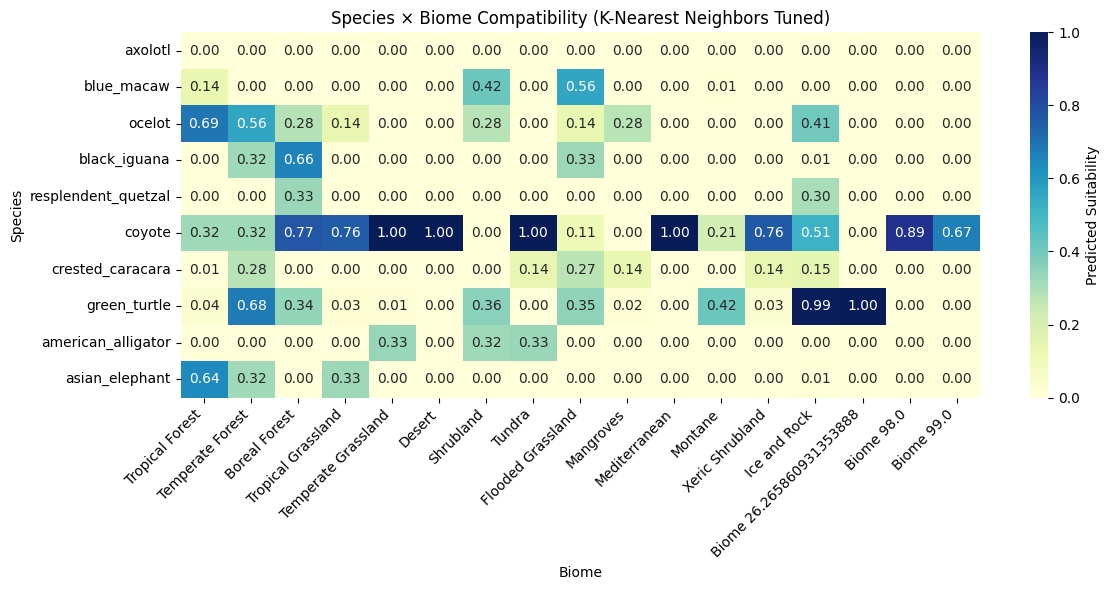

In [5]:
# Heatmap

import matplotlib.pyplot as plt
import seaborn as sns

heatmap_data = compatibility_matrix_knn_tuned.replace("–", np.nan).astype(float)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={"label": "Predicted Suitability"})
plt.title("Species × Biome Compatibility (K-Nearest Neighbors Tuned)")
plt.xlabel("Biome")
plt.ylabel("Species")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()